<font size=4 color=#376cb0 face=华文中宋 weight=50 line-heiht=100px>&emsp;&ensp;此脚本可以实现 ——
1. 对MySQL数据进行读取和下载，并对原始数据做出转换，所用转换系数读取自excel表而非数据库中错误的转换系数
2. 生成SQL命令行，以查询数据库中每个表格（对应各采集设备）的行数和首尾时间戳，以此确定数据可用性
3. 绘制采集设备可用性的时间视图
4. 绘制某单测点可用性的时间视图
5. 对缺失和过饱和问题不严重的数据，制作处理方案表单
6. 给出设备型号列表和所需数据时间段的首尾，即可从MySQL数据库中批量导出数据，默认进行数据插补或删减修复，并转存成内存占用更少的pkl格式，存储占用为原txt格式的1/5，同时，下载时会自动绕开已下载部分
7. 给出设备型号和所需数据时间段的首尾，即可一键绘制时间序列图：会根据处理方案表单自动查询数据不存在和数据不可用的问题，并及时反馈说明无法绘图的原因；对于数据可用但未下载到本地的情况，会有提示下载的交互操作，确认后会自动执行下载-修复-转存等一系列操作（下载时会自动绕开已下载部分），然后自动执行绘图
8. 在绘图处提供了临时修改具体绘图设置的cell，方便及时改动
</font>

# Prepare

In [1]:
import os
import sys
import MySQLdb
import warnings
import numpy as np
import pandas as pd
import pickle as pkl
from math import log
import altair as alt
alt.renderers.enable('notebook')
warnings.filterwarnings("ignore")
from datetime import datetime as datetime
alt.data_transformers.enable('default', max_rows = None) # 避免警告数据量超过5000
pd.set_option('display.max_columns', 20) # 显示所有列
pd.set_option('display.max_rows', 60) # 显示所有行
pd.set_option('max_colwidth',100) # 设置value的显示长度为100，默认为50

root_dir = 'H://SHZX_output'
exp_instrument_info_path = root_dir+'//Others//exp_instrument_info.xlsx'
table_list_path = root_dir+'//Others//table_list.txt'
sql_command_for_rows_path = root_dir+'//Others//行数查询sql命令.txt'
table_rows_path = root_dir+'//Others//table_rows.txt'
data_repair_info_path = root_dir+'//Others//data_repair_info.pkl'

# 了解数据概况
def get_exp_info(table_rows_path): # 缺失率最多为1%且时间段完整的exp数据为可用数据
    with open(table_rows_path, 'r') as f:
        table_rows = pd.read_csv(f, delimiter='\t', header=None)
    table_rows.columns=['编号', '行数', '开始时间', '结束时间']
    table_rows['类型'] = 0 # 不可用
    exp_info = table_rows[table_rows['编号'].str.contains('exp')]
    exp_info.loc[(exp_info['行数']>8640000*(1-1/100))& (exp_info['行数']<8640000) & (exp_info['开始时间'].str.contains('00:00:00'))\
                 & (exp_info['结束时间'].str.contains('23:59:59')), ['类型']] = 1 # 小于8640000
    exp_info.loc[(exp_info['行数']==8640000) & (exp_info['开始时间'].str.contains('00:00:00'))\
                 & (exp_info['结束时间'].str.contains('23:59:59')), ['类型']] = 2 # 等于8640000
    exp_info.loc[(exp_info['行数']>8640000) & (exp_info['开始时间'].str.contains('00:00:00'))\
                 & (exp_info['结束时间'].str.contains('23:59:59')), ['类型']] = 3 # 大于8640000
    exp_info.loc[:,'设备'] = exp_info['编号'].apply(lambda x: '_'.join(x.split('_')[:2]))
    exp_info.loc[:,'日期'] = pd.to_datetime(exp_info['编号'].apply(lambda x: '-'.join(x.split('_')[2:])))
    return(exp_info)

def choose_instrument_series(instrument_number):
    instrument_info = pd.read_excel(exp_instrument_info_path, sheet_name='exp_instrument_info')
    instrument_series = instrument_info[instrument_info['number']==instrument_number]['Instru_serial'].values[0]
    instrument_series = 'exp_%s'%instrument_series
    return(instrument_series)

# 导出数据
## 导出SQL数据
def get_i_code_path(i_code, i_date):
    i_code_number = i_code + '_' + i_date
    i_data_path = root_dir + '//' + i_code_number + '.txt'
    return(i_code_number, i_data_path)
    
def get_ratios(i_code, exp_instrument_info_path):
    instrument_info = pd.read_excel(exp_instrument_info_path, sheet_name='exp_instrument_info')
    try:
        ratios = instrument_info[instrument_info['number']==i_code]['ratios'].values[0]
    except:
        ratios = ''
    return(ratios)

def get_Instru_serial(cursor, table, code):
    sql = "select * from %s where number = '%s'" % (table, code)
    try:
        cursor.execute(sql)
        results = cursor.fetchone()
        return results
    except Exception as ex:
        print(Exception, ':', ex)

def get_data_table(cursor, serial, date_str):
    if date_str == '':
        sql = '''select * from relationtable where Instru_serial = '%s'
            ''' % (serial)
    else:
        sql = '''select * from relationtable where Instru_serial = '%s'
                and time = '%s' ''' % (serial, date_str)
    try:
        cursor.execute(sql)
        result = cursor.fetchone()
        _, _, data_table, _, _ = result
        return data_table
    except Exception as ex:
        print(Exception, ':', ex)

def get_stress_data(table, channel, i_data_path, i_date, ratios):
    rk, rf, _ = ratios.split(',')
    rk = float(rk)
    rf = float(rf)
    print("rk: %f\t rf: %f\n" % (rk, rf))
    f_i = 'F'+str(channel)
    r_i = 'R'+str(channel)
    sql = '''select cur_time, %s, %s from %s where DATE(cur_time) = '%s' ''' % (f_i, r_i, table, i_date)
    # print(sql)
    try:
        cur.execute(sql)
        fh = open(i_data_path, 'w')
        for (cur_time, f_i, r_i) in cur:
            if r_i == 0 or f_i == 0: continue
            fh.write("%s\t%.3f\t%.2f\n" % (cur_time, f_i/10.0 ,
                    1/(1.4051e-3 + 2.369e-4 * log(r_i) + 1.019e-7* (log(r_i))**3) - 273.2))
        fh.close()
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_exp_data(table, channel, i_data_path):
    data_i = 'data'+str(channel)
    sql = '''select cur_time, %s into outfile '%s' fields
            terminated by '\t' from %s '''  % (data_i,i_data_path,table)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_qx_data(table, channel, i_data_path, ratios, time1, time2): #倾角仪
    ratios = float(ratios)
    data_i = 'data'+str(channel)
    sql = '''select cur_time, asin(%s/21.64)-%f as qx into outfile '%s' fields
            terminated by '\t' from %s where cur_time between '%s' and '%s' '''  % (data_i,ratios,i_data_path,table,time1,time2)
    # print(sql)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_fy_data(table, channel, i_data_path, ratios, time1, time2): #风压
    (rb, rc) = ratios.split(',')
    rb = float(rb)
    rc = float(rc)
    data_i = 'data'+str(channel)
    sql = '''select cur_time, %s*%f-%f as fy into outfile '%s' fields
            terminated by '\t' from %s where cur_time between '%s' and '%s' '''  % (data_i,rb,rc,i_data_path,table,time1,time2)
    # print(sql)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_wyj_data(table, channel, i_data_path, ratios, time1, time2): #阻尼位移计
    (rb, rc) = ratios.split(',')
    rb = float(rb)
    rc = float(rc)
    data_i = 'data'+str(channel)
    sql = '''select cur_time, %s*%f+%f as fy into outfile '%s' fields
            terminated by '\t' from %s where cur_time between '%s' and '%s' '''  % (data_i,rb,rc,i_data_path,table,time1,time2)
    # print(sql)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_fz_data(table, channel, i_data_path, ratios, time1, time2): #风振
    ra = float(ratios)
    data_i = 'data'+str(channel)
    sql = '''select cur_time, %s*%f as fz into outfile '%s' fields
            terminated by '\t' from %s where cur_time between '%s' and '%s' '''  % (data_i,ra,i_data_path,table,time1,time2)
    # print(sql)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_zd_data(table, channel, i_data_path, ratios, time1, time2): #加速度
    ra = float(ratios)
    data_i = 'data'+str(channel)
    sql = '''select cur_time, %s*%f as zd into outfile '%s' fields
            terminated by '\t' from %s where cur_time between '%s' and '%s' '''  % (data_i,ra,i_data_path,table,time1,time2)
    # print(sql)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_gps_data(table, i_data_path):
    sql = '''select * into outfile '%s' fields
            terminated by '\t' from %s ''' % (i_data_path, table)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_temp_data(table, channel, i_data_path, i_date): #温度
    data_i = 'data'+str(channel)
    sql = '''select cur_time, %s*0.1 as temp into outfile '%s' fields
            terminated by '\t' from %s where DATE(cur_time) = '%s' ''' % (data_i,i_data_path, table, i_date)
    # print(sql)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_fs_data(table, i_data_path, i_code, time1, time2): #风速风向
    if i_code == 'FS-132-01':
        sql = '''select cur_time, data1*10, data2*108 into
                outfile '%s' fields terminated by '\t' from %s where cur_time between '%s' and '%s' ''' % (i_data_path, table, time1, time2)
        # print(sql)
    else:
        sql = '''select cur_time, data6*25-25, data5*90-90 into
                outfile '%s' fields terminated by '\t' from %s where cur_time between '%s' and '%s' ''' % (i_data_path, table, time1, time2)
        # print(sql)
    try:
        cur.execute(sql)
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def get_crack_data(table, channel, i_data_path, i_date): #裂缝
    data_i = 'data'+str(channel)
    sql = '''select cur_time, %s from %s where DATE(cur_time) = '%s' ''' % (data_i, table, i_date)
    try:
        fh = open(i_data_path, 'w')
        cur.execute(sql)
        for (cur_time, data_i) in cur:
            fh.write("%s\t%.2f\n" %(cur_time, data_i))
        fh.close()
        print(i_data_path, 'done')
    except Exception as ex:
        print(Exception, ':', ex)

def convert_date(i_date): # 数据库中的日期是8_13这种而不是08_13，故需做此转换
    cells = i_date.split('-')
    i_year = cells[0]
    i_month = int(cells[1])
    i_day = int(cells[2])
    date_str = i_year+'_'+str(i_month)+'_'+str(i_day)
    return(date_str)

def get_sets(i_data_path):
    sets = []
    fh = open(i_data_path, 'r')
    for line in fh.readlines():
        i_content = line.split()
        sets.append(i_content)
    fh.close()
    return(sets)

def get_database_local():
    conn = MySQLdb.connect(
        host = '127.0.0.1',
        port = 3306,
        user = 'root',
        passwd='1234',
        db = 'aiot',
        charset='utf8'
        )
    cur = conn.cursor()
    return(conn,cur)

def SQL_data_export(i_date, time1, time2, i_code, cur, root_dir, ratios):
    if not os.path.exists(root_dir): os.makedirs(root_dir)
    date_str = convert_date(i_date)
    i_data_path = get_i_code_path(i_code, i_date)[1]

    if 'mqyb' in i_code or 'ST' in i_code:
        i_info_table = 'dvw16_instrument_info'
        serial, channel, _, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, '')
        get_stress_data(data_table, channel, i_data_path, i_date, ratios)

    elif 'QX' in i_code: #倾角仪
        i_info_table = 'exp_instrument_info'
        serial, channel, _, _, _, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, date_str)
        # print(data_table)
        get_qx_data(data_table, channel, i_data_path, ratios, time1, time2)

    elif 'FY' in i_code: #风压
        i_info_table = 'exp_instrument_info'
        serial, channel, _, _, _, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, date_str)
        # print(data_table)
        get_fy_data(data_table, channel, i_data_path, ratios, time1, time2)

    elif 'WYJ' in i_code: #位移计
        i_info_table = 'exp_instrument_info'
        serial, channel, _, _, _, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, date_str)
        # print(data_table)
        get_wyj_data(data_table, channel, i_data_path, ratios, time1, time2)

    elif 'FZ' in i_code: #风振
        i_info_table = 'exp_instrument_info'
        serial, channel, _, _, _, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, date_str)
        # print(data_table)
        get_fz_data(data_table, channel, i_data_path, ratios, time1, time2)

    elif 'ZD' in i_code: #加速度
        i_info_table = 'exp_instrument_info'
        serial, channel, _, _, _, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, date_str)
        # print(data_table)
        get_zd_data(data_table, channel, i_data_path, ratios, time1, time2)

    elif 'FS' in i_code: #风速
        # print('exp_instrument_info')
        i_info_table = 'exp_instrument_info'
        serial, _, _, _, _, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, date_str)
        # print(data_table)
        get_fs_data(data_table, i_data_path, i_code, time1, time2)

    elif 'GPS' in i_code: #GPS
        # print('gps_instrument_info')
        i_info_table = 'gps_instrument_info'
        serial,_ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, date_str)
        # print(data_table)
        get_gps_data(data_table, i_data_path)

    elif 'FLC' in i_code: #裂缝
        # print('crack_instrument_info')
        i_info_table = 'crack_instrument_info'
        serial,channel,_ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, '')
        get_crack_data(data_table, channel, i_data_path, i_date)

    elif 'WD' in i_code: #温度
        # print('temperature_instrument_info')
        i_info_table = 'temperature_instrument_info'
        serial, channel, _ = get_Instru_serial(cur, i_info_table, i_code)
        data_table = get_data_table(cur, serial, '')
        get_temp_data(data_table, channel, i_data_path, i_date)
    else:
        print('no result')
        
## 数据修复
def repair_data(i_code, i_date):
    with open(data_repair_info_path, 'rb') as f:
        data_repair_info = pkl.load(f)
    i_code_repair_info = data_repair_info[data_repair_info['编号']==choose_instrument_series(i_code)+'-'+i_date.replace('-','_')]
    i_code_number, i_data_path = get_i_code_path(i_code, i_date)
    if 'FS' in i_code:
        if i_code_repair_info['类型'].values[0] == 0:
            print(i_code_number+' 不可用，故未进行修复并删除')
        elif i_code_repair_info['类型'].values[0] == 1:
            with open(i_data_path, 'r') as f:
                i_data = pd.read_csv(f, header=None, delimiter='\t', usecols=[1,2])
            wind_speed = i_data[1].tolist()
            wind_direction = i_data[2].tolist()
            for i in i_code_repair_info['插入或删除'].values[0]: # 插入
                wind_speed.insert(i, (wind_speed[i-1]+wind_speed[i])/2)
            for i in i_code_repair_info['插入或删除'].values[0]: # 插入
                wind_direction.insert(i, wind_direction[i])
            i_data = pd.DataFrame({'wind_speed':wind_speed, 'wind_direction':wind_direction})
            with open(i_data_path.replace('.txt','.pkl'), 'wb') as f:
                pkl.dump(i_data, f)
        elif i_code_repair_info['类型'].values[0] == 2:
            with open(i_data_path, 'r') as f:
                i_data = pd.read_csv(f, header=None, delimiter='\t', usecols=[1,2])
            i_data.columns = ['wind_speed', 'wind_direction']
            with open(i_data_path.replace('.txt','.pkl'), 'wb') as f:
                pkl.dump(i_data, f)
        elif i_code_repair_info['类型'].values[0] == 3:
            with open(i_data_path, 'r') as f:
                i_data = pd.read_csv(f, header=None, delimiter='\t', usecols=[1,2])
            wind_speed = i_data[1].tolist()
            wind_direction = i_data[2].tolist()
            for i in i_code_repair_info['插入或删除'].values[0]: # 删减
                wind_speed.pop(i)
            for i in i_code_repair_info['插入或删除'].values[0]: # 删减
                wind_direction.pop(i)
            i_data = pd.DataFrame({'wind_speed':wind_speed, 'wind_direction':wind_direction})
            with open(i_data_path.replace('.txt','.pkl'), 'wb') as f:
                pkl.dump(i_data, f)
    else:
        if i_code_repair_info['类型'].values[0] == 0:
            print(i_code_number+' 不可用，故未进行修复并删除')
        elif i_code_repair_info['类型'].values[0] == 1:
            with open(i_data_path, 'r') as f:
                i_data = pd.read_csv(f, header=None, delimiter='\t', usecols=[1])[1].tolist()
            for i in i_code_repair_info['插入或删除'].values[0]: # 插入
                i_data.insert(i, (i_data[i-1]+i_data[i])/2)
            i_data = pd.DataFrame(i_data, columns=[i_code.split('-')[0]])
            with open(i_data_path.replace('.txt','.pkl'), 'wb') as f:
                pkl.dump(i_data, f)
        elif i_code_repair_info['类型'].values[0] == 2:
            with open(i_data_path, 'r') as f:
                i_data = pd.read_csv(f, header=None, delimiter='\t', usecols=[1])
            i_data.columns = [i_code.split('-')[0]]
            with open(i_data_path.replace('.txt','.pkl'), 'wb') as f:
                pkl.dump(i_data, f)
        elif i_code_repair_info['类型'].values[0] == 3:
            with open(i_data_path, 'r') as f:
                i_data = pd.read_csv(f, header=None, delimiter='\t', usecols=[1])[1].tolist()
            for i in i_code_repair_info['插入或删除'].values[0]: # 删减
                i_data.pop(i)
            i_data = pd.DataFrame(i_data, columns=[i_code.split('-')[0]])
            with open(i_data_path.replace('.txt','.pkl'), 'wb') as f:
                pkl.dump(i_data, f)
    os.remove(i_data_path) # 修复好之后就可以删除了

## 导出数据
def data_export(code_list, date_list):
    for i_code in code_list:
        for i_date in date_list:
            i_data_path = get_i_code_path(i_code, i_date)[1].replace('.txt','.pkl')
            if not os.path.exists(i_data_path):
                ratios = get_ratios(i_code, exp_instrument_info_path)
                SQL_data_export(i_date, '00:00:00', '23:59:59.999999', i_code, cur, root_dir, ratios) # 数据导出
                repair_data(i_code, i_date) # 数据修复并删除txt
            
# 导入数据(若不存在，则提示下载)并合并数据
## 获取时间列表
def get_date_list(date_start, date_end):
    date_list = [x.strftime('%Y-%m-%d') for x in pd.date_range(date_start, date_end)]    
    return(date_list)

## 检查数据是否已下载到本地
def judge_data_all_exist(i_code, desired_date_list):
    data_all_exist = 1
    undownload_date_list = []
    for i_date in desired_date_list:
        i_data_path = get_i_code_path(i_code, i_date)[1].replace('.txt','.pkl')
        if not os.path.exists(i_data_path):
            undownload_date_list.append(i_date)
            data_all_exist = 0
    return(data_all_exist, undownload_date_list)

## 检查绘图数据完备性
def judge_data_completeness(i_code, date_start, date_end):
    data_completeness = 0
    exp_info = get_exp_info(table_rows_path)
    i_code_info = exp_info[exp_info['设备']==choose_instrument_series(i_code)]
    desired_date_list = get_date_list(date_start, date_end)
    happy_date_list = [x.strftime('%Y-%m-%d') for x in i_code_info[i_code_info['类型']>0]['日期']] # 可用数据的日期
    sorry_date_list = list(set(desired_date_list)-set(happy_date_list)) # 不可用数据的日期
    hope_date_list = list(set(sorry_date_list)&set([x.strftime('%Y-%m-%d') \
                     for x in i_code_info[i_code_info['类型']==0]['日期']])) # 未修复数据的日期
    bad_date_list = list(set(sorry_date_list)-set(hope_date_list)) # 不存在数据的日期
    if sorry_date_list:
        if bad_date_list:
            print('对于%s，以下日期的数据不存在，故无法绘图：\n%s'%(i_code, sorted(bad_date_list)))
        if hope_date_list:
            print('对于%s，以下日期的数据未修复，故无法绘图：\n%s'%(i_code, sorted(hope_date_list)))
    else:
        data_all_exist, undownload_date_list = judge_data_all_exist(i_code, desired_date_list)
        if data_all_exist:
            data_completeness = 1
        else:
            print(undownload_date_list)
            print('对于%s，以上日期的数据未下载到本地，是否要下载？（y or n）'%i_code)
            download = input()
            if download=='y':
                data_completeness = 1
                print('开始下载，请等待...')
                data_export([i_code], undownload_date_list)
            else:
                print('未执行数据下载，数据不在本地，故无法绘图')
    return(data_completeness)
    
## 获得各类型数据
def get_i_data(i_code, i_date):
    i_data_path = get_i_code_path(i_code, i_date)[1].replace('.txt','.pkl')
    with open(i_data_path, 'rb') as f:
        i_data = pkl.load(f)
    i_date_start = pd.Timestamp(i_date)
    i_date_end = i_date_start + pd.Timedelta('1D')
    i_data.index = pd.date_range(i_date_start, i_date_end, freq='10L', closed='left')
    return(i_data)
    
def get_data_std(i_code, date_start, date_end, resample_frequency):
    data_std = pd.DataFrame()
    if judge_data_completeness(i_code, date_start, date_end): 
        for i_date in get_date_list(date_start, date_end):
            i_data_std = get_i_data(i_code, i_date).resample(resample_frequency).std()
            data_std = data_std.append(i_data_std)
    return(data_std)

def get_data_mean(i_code, date_start, date_end, resample_frequency):
    data_mean = pd.DataFrame()
    if judge_data_completeness(i_code, date_start, date_end): 
        for i_date in get_date_list(date_start, date_end):
            i_data_mean = get_i_data(i_code, i_date).resample(resample_frequency).mean()
            data_mean = data_mean.append(i_data_mean)
    return(data_mean)

def get_data_head(i_code, date_start, date_end, resample_frequency):
    data_head = pd.DataFrame()
    if judge_data_completeness(i_code, date_start, date_end): 
        for i_date in get_date_list(date_start, date_end):
            i_data_head = get_i_data(i_code, i_date).resample(resample_frequency).head()
            data_head = data_std.append(i_data_head)
    return(data_head)

def get_data_tail(i_code, date_start, date_end, resample_frequency):
    data_tail = pd.DataFrame()
    if judge_data_completeness(i_code, date_start, date_end): 
        for i_date in get_date_list(date_start, date_end):
            i_data_tail = get_i_data(i_code, i_date).resample(resample_frequency).tail()
            data_tail = data_std.append(i_data_tail)
    return(data_tail)

# 绘图
## 绘图设置 (正式绘图处还有一份，是用来临时修改的)
def alt_configure(chart):
    chart = (chart
             .properties(width=950, height=200)
             .configure_title(font='Times New Roman', fontSize=18, fontWeight='bold')
             .configure_axis(titleFontSize=16, labelFontSize=12, labelFont='Times New Roman', titleFont='Times New Roman')
             .configure_legend(title=None, labelFont='Times New Roman',labelFontSize=15, labelFontWeight='bold',
                               orient='top-left', symbolStrokeWidth=4, symbolSize=300,
                               rowPadding=15, labelLimit=400, symbolOffset=15)
             #.interactive(bind_y = False) # 交互性设置
            )
    return(chart)
    
## 绘图：ZD
def draw_ZD(data, title):
    ZD_chart = (alt
                .Chart(data.reset_index(), title=title)
                .mark_line(strokeWidth=2, strokeOpacity=0.9)
                .encode(alt.X('index:T', title=None, axis=alt.Axis(format='%d-%0H:%0M')),
                        alt.Y('ZD:Q', title='Acceleration (m/s²)', axis=alt.Axis(format='e')))
                )
    alt_configure(ZD_chart).display()
    
## 绘图：FS
def draw_FS1(data, title): # 风速
    F1_chart = (alt
                .Chart(data['wind_speed'].reset_index(), title=title)
                .mark_line(strokeWidth=2, strokeOpacity=0.9)
                .encode(alt.X('index:T', title=None, axis=alt.Axis(format='%d-%0H:%0M')),
                        alt.Y('wind_speed:Q', title='Wind Speed (m/s)'))
                )
    alt_configure(F1_chart).display()
def draw_FS2(data, title): # 风向
    F2_chart = (alt
                .Chart(data['wind_direction'].reset_index(), title=title)
                .mark_line(strokeWidth=2, strokeOpacity=0.9)
                .encode(alt.X('index:T', title=None, axis=alt.Axis(format='%d-%0H:%0M')),
                        alt.Y('wind_direction:Q', title='Wind Direction (°)'))
                )
    alt_configure(F2_chart).display()
def draw_FS3(data, title): # 风速*sin(风向)
    data['wind_speed'] = data['wind_speed']*np.sin(np.deg2rad(data['wind_direction']))
    F3_chart = (alt
                .Chart(data['wind_speed'].reset_index(), title=title)
                .mark_line(strokeWidth=2, strokeOpacity=0.9)
                .encode(alt.X('index:T', title=None, axis=alt.Axis(format='%d-%0H:%0M')),
                        alt.Y('wind_speed:Q', title='Wind Speed (m/s)'))
                )
    alt_configure(F3_chart).display()

def draw_FS4(data, title): # 风速*cos(风向)
    data['wind_speed'] = data['wind_speed']*np.cos(np.deg2rad(data['wind_direction']))
    F4_chart = (alt
                .Chart(data['wind_speed'].reset_index(), title=title)
                .mark_line(strokeWidth=2, strokeOpacity=0.9)
                .encode(alt.X('index:T', title=None, axis=alt.Axis(format='%d-%0H:%0M')),
                        alt.Y('wind_speed:Q', title='Wind Speed (m/s)'))
                )
    alt_configure(F4_chart).display()
    
# 启动SQL
conn, cur = get_database_local()

# 了解数据概况

## 生成查询表格行数的SQL命令

In [20]:
# 生成table_list
sql = '''SELECT table_name INTO outfile '%s' fields terminated by '\t'
FROM information_schema.TABLES WHERE table_schema = 'aiot' '''%table_list_path
if not os.path.exists(table_list_path):
    cur.execute(sql)

# 生成查询表格行数的SQL命令
with open(table_list_path, 'r') as f:
    table_list = pd.read_csv(f, header=None)
table_list = [x for x in table_list[0] if 'temperture' in x or 'exp' in x and 'exp_instrument_info' not in x or 'vibration' in x or 'crack' in x and 'crack_instrument_info' not in x]
table_list = ["SELECT '%s' table_name, COUNT(*) rows, MIN(cur_time) head, MAX(cur_time) tail FROM %s UNION"%(x,x) for x in table_list]
sql = '\n'.join(table_list)
sql = sql[:-5] + "\nINTO outfile '%s' fields terminated by '\t'"%table_rows_path
with open(sql_command_for_rows_path, 'w') as f: # 将查询到的表格行数存成一份txt
    f.writelines(sql)
# cur.execute(sql)

## 绘制设备可用性视图

In [ ]:
exp_info = get_exp_info(table_rows_path)
alt.Chart(exp_info).mark_rect().encode(
    x='yearmonthdate(日期):O',
    y='设备:O',
    color=alt.Color('类型:Q', scale=alt.Scale(range=['#999999', '#f58519', '#54a24c', '#4c78a7'])),
    tooltip=[alt.Tooltip('类型:O', title='类型'),
             alt.Tooltip('行数:Q', title='行数'), 
             alt.Tooltip('设备:O', title='设备'),
             alt.Tooltip('日期:T', title='日期'),
             alt.Tooltip('开始时间:O', title='开始时间'), 
             alt.Tooltip('结束时间:O', title='结束时间')]
).properties(width=2000, height=500)

## 绘制测点可用性视图

In [ ]:
i_code = 'ZD-117-01'
exp_info = get_exp_info(table_rows_path)
alt.Chart(exp_info[exp_info['设备']==choose_instrument_series(i_code)]).mark_rect().encode(
    x=alt.X('date(日期):O', title='Date'),
    y=alt.Y('month(日期):O', title='Month'),
    color=alt.Color('类型:Q', scale=alt.Scale(range=['#999999', '#f58519', '#54a24c', '#4c78a7'])),
    tooltip=[alt.Tooltip('类型:O', title='类型'),
             alt.Tooltip('行数:Q', title='行数'), 
             alt.Tooltip('设备:O', title='设备'),
             alt.Tooltip('日期:T', title='日期'),
             alt.Tooltip('开始时间:O', title='开始时间'), 
             alt.Tooltip('结束时间:O', title='结束时间')]
).properties(width=1000, height=200)

## 对缺失数据或过饱和数据制作处理方案表单

In [ ]:
exp_info = get_exp_info(table_rows_path)
exp_info0 = exp_info[exp_info['类型']==0] # 小于8640000*(1-1/100)
exp_info1 = exp_info[exp_info['类型']==1] # 小于8640000
exp_info2 = exp_info[exp_info['类型']==2] # 等于8640000
exp_info3 = exp_info[exp_info['类型']==3] # 大于8640000
exp_info0['插入或删除'] = ''; exp_info2['插入或删除'] = '';
exp_info1['插入或删除'] = exp_info1['行数'].apply(lambda x: np.linspace(2, x, 8640000-x, endpoint=False, dtype=int)+range(1,8640001-x))
exp_info3['插入或删除'] = exp_info3['行数'].apply(lambda x: np.linspace(2, x, x-8640000, endpoint=False, dtype=int)-range(1,x-8639999))
data_repair_info = pd.concat([exp_info0,exp_info1,exp_info2,exp_info3], ignore_index=True)
data_repair_info['编号'] = data_repair_info.apply(lambda x:x['设备']+'-'+x['日期'].strftime('%Y-%m-%d').replace('-','_'), axis=1)
data_repair_info = data_repair_info[['编号', '类型', '插入或删除']]
with open(data_repair_info_path, 'wb') as f:
    pkl.dump(data_repair_info, f)

# 数据批量导出

In [ ]:
# 数据展示可以对单测点进行导出，此处是为了方便批量导出
date_start = '2018-08-16'; date_end = '2018-08-17'
code_list = ['ZD-117-01','ZD-117-02','ZD-117-03','ZD-117-04',
             'ZD-124-01','ZD-124-02','ZD-124-03','ZD-124-04',
             'ZD-125-01','ZD-125-02','ZD-125-03','ZD-125-04',
             'FS-132-01','FS-132-02'
              ]
date_list = get_date_list(date_start, date_end)
data_export(code_list, date_list)

# 数据展示

## 绘图设置

In [29]:
def alt_configure(chart):
    chart = (chart
             .properties(width=950, height=200)
             .configure_title(font='Times New Roman', fontSize=18, fontWeight='bold')
             .configure_axis(titleFontSize=16, labelFontSize=12, labelFont='Times New Roman', titleFont='Times New Roman')
             .configure_legend(title=None, labelFont='Times New Roman',labelFontSize=15, labelFontWeight='bold',
                               orient='top-left', symbolStrokeWidth=4, symbolSize=300,
                               rowPadding=15, labelLimit=400, symbolOffset=15)
             .interactive(bind_y = False) # 交互性设置
            )
    return(chart)

## ZD

In [ ]:
i_code = 'ZD-117-01'
date_start = '2018-8-16'; date_end = '2018-8-17'
resample_frequency = '2T'
data = get_data_std(i_code, date_start, date_end, resample_frequency)
draw_ZD(data, i_code)

## FS

In [ ]:
i_code = 'FS-132-02'
date_start = '2018-08-16'; date_end = '2018-08-17'
resample_frequency = '2T'
data = get_data_mean(i_code, date_start, date_end, resample_frequency)
draw_FS1(data, i_code)
draw_FS2(data, i_code)

## 闲鱼计算

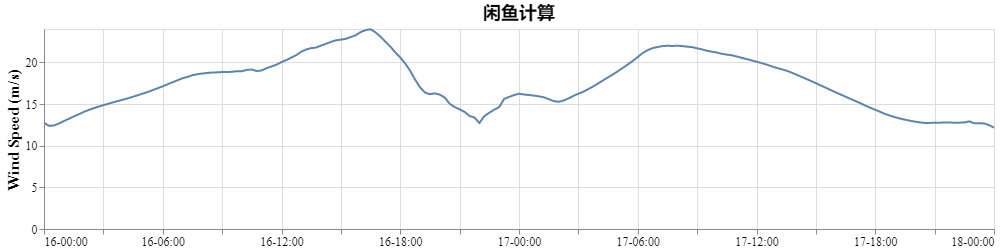

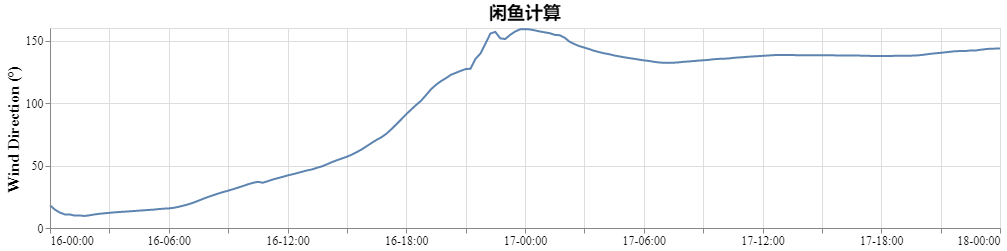

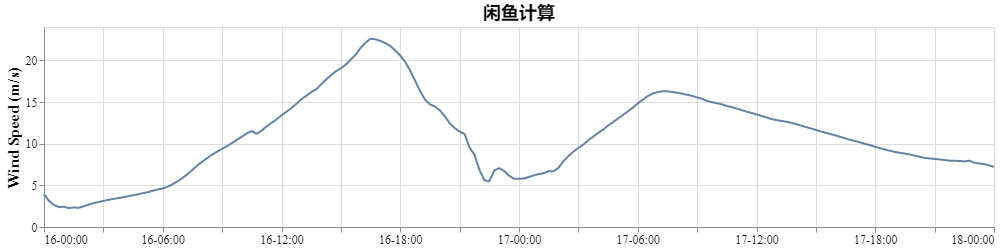

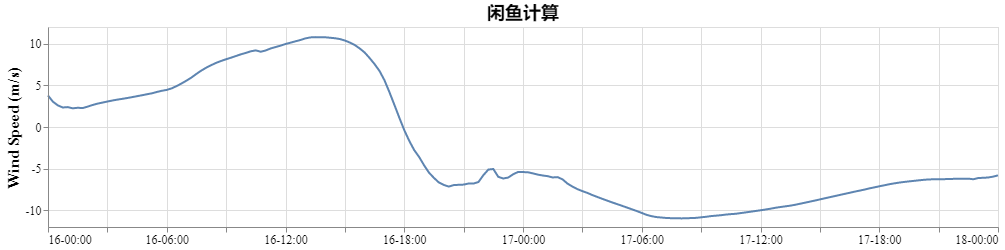

In [3]:
file = 'E:\【论文】\【大论文】\气象资料收集\WRF计算\lujiazui_[(121.511999000000,31.239185000000), 1, 632].csv'
data = pd.read_csv(file, skiprows=9)[['speed','direction']]
data.columns = ['wind_speed', 'wind_direction']
data.index = pd.date_range('2018-08-16', '2018-08-18', freq='15T')
draw_FS1(data['2018-08-16': '2018-08-18'], '闲鱼计算')
draw_FS2(data['2018-08-16': '2018-08-18'], '闲鱼计算')
draw_FS3(data['2018-08-16': '2018-08-18'], '闲鱼计算')
draw_FS4(data['2018-08-16': '2018-08-18'], '闲鱼计算')